# Tecniche di Ottimizzazione degli Iperparametri nel Machine Learning

L'ottimizzazione degli iperparametri, o tuning degli iperparametri, è il processo di ricerca del set ottimale di iperparametri per un algoritmo di machine learning. Mentre i parametri del modello vengono appresi durante l'addestramento, gli iperparametri sono impostati prima dell'inizio dell'addestramento e influenzano il modo in cui il modello apprende.

Questo notebook esplora varie tecniche e framework di ottimizzazione degli iperparametri, inclusi Optuna, Ray Tune, e Weights & Biases Sweeps, applicate all'algoritmo RandomForest.

## Sfide Comuni nell'Ottimizzazione degli Iperparametri:

- Ampi spazi di ricerca con molte possibili combinazioni
- Costi di valutazione elevati (tempo/risorse computazionali)
- Rischio di overfitting sui dati di validazione
- Paesaggi di ottimizzazione non convessi
- Iperparametri condizionali (parametri che hanno importanza solo quando altri hanno valori specifici)

## Perché è importante l'ottimizzazione degli iperparametri?

1. **Prestazioni del Modello**: Un corretto tuning degli iperparametri può migliorare significativamente l'accuratezza e la generalizzazione del modello.
2. **Efficienza**: Aiuta a utilizzare in modo efficiente le risorse computazionali.
3. **Robustezza**: I modelli ben sintonizzati tendono ad essere più robusti su diversi dataset.

### Il Processo di Tuning degli Iperparametri

1. Definire uno spazio di ricerca per gli iperparametri
2. Selezionare una strategia di campionamento
3. Definire una metrica di valutazione
4. Implementare un algoritmo di ricerca
5. Analizzare i risultati e selezionare i migliori iperparametri

In [17]:
# Installazione delle librerie necessarie
# !pip install optuna ray[tune] wandb scikit-learn seaborn plotly

In [1]:
# Importazione delle librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Impostazioni per le visualizzazioni
plt.style.use('ggplot')
seed = 42
np.random.seed(42)

In [3]:
# Caricamento di un dataset di esempio (Diabetes)
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Prima separazione: divide i dati in "temp" (che diventerà train+validation) e test finale (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.2, random_state=seed
)

# Seconda separazione: divide "temp" in train effettivo (80% del totale) e validation (20% del totale)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=seed  # 0.25 * 0.8 = 0.2 (20% del dataset originale)
)

In [4]:
# Definizione di una semplice funzione di valutazione del modello
def evaluate_model(model, X_eval_data, y_eval_data):
    """Valuta le prestazioni del modello e restituisce le metriche."""
    y_pred = model.predict(X_eval_data)
    mse = mean_squared_error(y_eval_data, y_pred)
    r2 = r2_score(y_eval_data, y_pred)
    return {
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R²": r2
    }

## Tecniche di Campionamento dei Parametri

Prima di immergerci nei framework specifici, comprendiamo le comuni tecniche di campionamento utilizzate nell'ottimizzazione degli iperparametri:

1. **Grid Search**: Ricerca esaustivamente attraverso un sottoinsieme specificato manualmente dello spazio degli iperparametri.
2. **Random Search**: Campiona casualmente dallo spazio degli iperparametri, trovando potenzialmente soluzioni migliori con meno iterazioni.
3. **Bayesian Optimization**: Costruisce un modello probabilistico della funzione obiettivo e lo utilizza per selezionare gli iperparametri più promettenti.

### Distribuzioni Comuni dei Parametri

- **Uniforme**: Uguale probabilità in un intervallo (buono per parametri dove non c'è una convinzione a priori)
- **Log-uniforme**: Campiona valori tali che i loro logaritmi siano distribuiti uniformemente (buono per i tassi di apprendimento)
- **Categorica**: Seleziona da opzioni discrete (buono per scelte di algoritmi o flag booleani)
- **Normale/Gaussiana**: Quando i valori vicino al centro hanno maggiori probabilità di essere ottimali

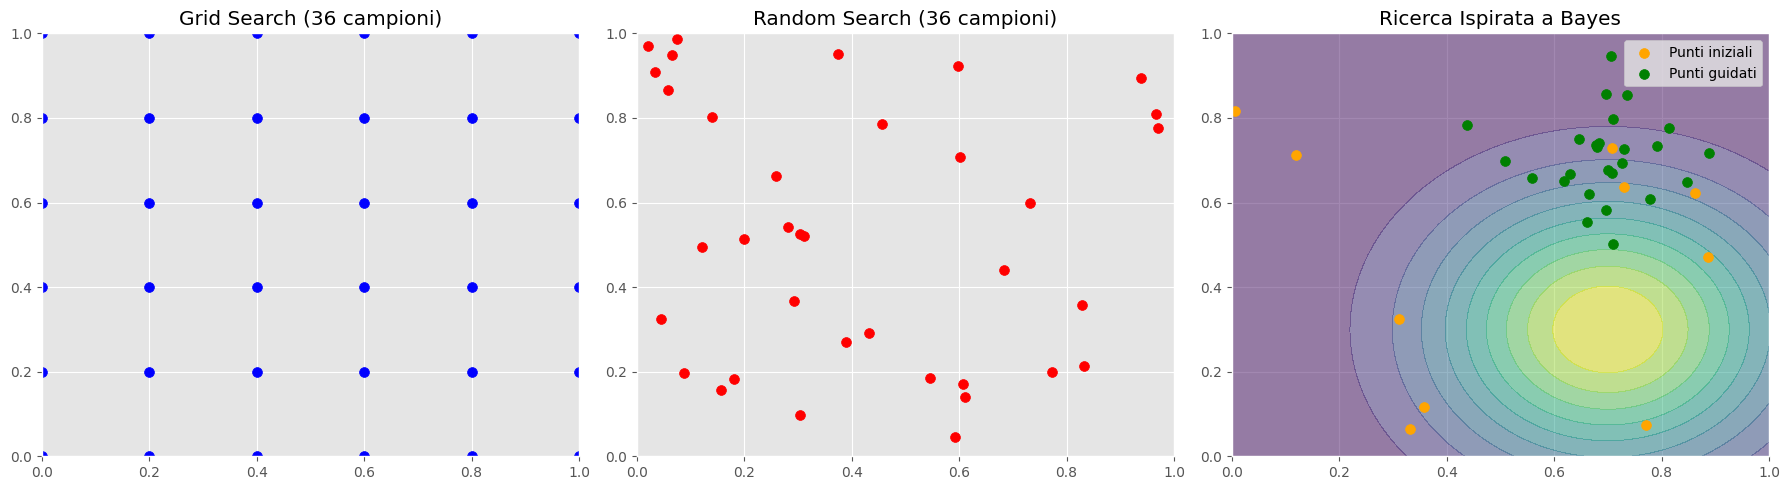

In [4]:
# Visualizzazione di diverse tecniche di campionamento dei parametri (Generato da Claude Sonnet)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grid Search
n_points_grid = 6
grid_x, grid_y = np.linspace(0, 1, n_points_grid), np.linspace(0, 1, n_points_grid)
grid_points = np.array([(x_val, y_val) for x_val in grid_x for y_val in grid_y])
axes[0].scatter(grid_points[:, 0], grid_points[:, 1], c='blue', s=50) 

# Random Search
random_points = np.random.rand(36, 2)
axes[1].scatter(random_points[:, 0], random_points[:, 1], c='red', s=50)

# Ricerca ispirata a Bayes (visualizzazione semplificata)
bay_points_initial = np.random.rand(10, 2)  # Punti casuali iniziali
x_coords, y_coords = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords)
Z_surrogate = np.exp(-((X_mesh - 0.7)**2 + (Y_mesh - 0.3)**2) / 0.1)  # Modello surrogato
axes[2].contourf(X_mesh, Y_mesh, Z_surrogate, levels=10, cmap='viridis', alpha=0.5)
axes[2].scatter(bay_points_initial[:, 0], bay_points_initial[:, 1], c='orange', s=50, label='Punti iniziali')
guided_points = 0.7 + np.random.randn(26, 2) * 0.1 # Punti guidati aggiuntivi
guided_points = np.clip(guided_points, 0, 1)
axes[2].scatter(guided_points[:, 0], guided_points[:, 1], c='green', s=50, label='Punti guidati')
axes[2].legend()

for ax, title in zip(axes, ['Grid Search (36 campioni)', 'Random Search (36 campioni)', 'Ricerca Ispirata a Bayes']):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 2. Optuna: Framework Avanzato per l'Ottimizzazione degli Iperparametri

[Optuna](https://optuna.org/) è un framework di ottimizzazione automatica degli iperparametri che offre:

- Algoritmi di campionamento efficienti
- Pruning (potatura) automatico dei trial non promettenti
- Ottimizzazione parallela e distribuita
- Visualizzazioni per l'analisi dei risultati

In [5]:
import optuna

def objective_optuna(trial):
    # Definizione dello spazio di ricerca
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    
    # Creazione e addestramento del modello
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=seed,
        n_jobs=-1
    )
    
    # Addestramento su train
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_val, y_val)

    return metrics['MSE']

c:\users\jackm\pythonprojects\tutoraggio-ingegneria-del-software_iada_\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Creazione e ottimizzazione dello studio Optuna
study_optuna = optuna.create_study(direction='minimize')
study_optuna.optimize(objective_optuna, n_trials=5)

# Risultati migliori
print("Migliori iperparametri (Optuna): ", study_optuna.best_params)
print("Miglior MSE (Optuna): ", study_optuna.best_value)

[I 2025-05-20 10:38:01,295] A new study created in memory with name: no-name-3b3e6415-c92c-4f54-b438-a716b3d63ca2
[I 2025-05-20 10:38:01,959] Trial 0 finished with value: 2998.327281740697 and parameters: {'n_estimators': 155, 'max_depth': 20}. Best is trial 0 with value: 2998.327281740697.
[I 2025-05-20 10:38:02,449] Trial 1 finished with value: 2974.701586147099 and parameters: {'n_estimators': 112, 'max_depth': 29}. Best is trial 1 with value: 2974.701586147099.
[I 2025-05-20 10:38:03,123] Trial 2 finished with value: 3005.798620107831 and parameters: {'n_estimators': 151, 'max_depth': 36}. Best is trial 1 with value: 2974.701586147099.
[I 2025-05-20 10:38:03,534] Trial 3 finished with value: 2968.9730046304426 and parameters: {'n_estimators': 64, 'max_depth': 21}. Best is trial 3 with value: 2968.9730046304426.
[I 2025-05-20 10:38:04,362] Trial 4 finished with value: 2990.195149465946 and parameters: {'n_estimators': 180, 'max_depth': 39}. Best is trial 3 with value: 2968.973004630

Migliori iperparametri (Optuna):  {'n_estimators': 64, 'max_depth': 21}
Miglior MSE (Optuna):  2968.9730046304426


In [9]:
# Valutazione del modello ottimizzato con Optuna
best_params_optuna = study_optuna.best_params
optuna_model = RandomForestRegressor(
    **best_params_optuna,  # Usiamo tutti i parametri trovati da Optuna
    random_state=seed,
    n_jobs=-1
)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])
optuna_model.fit(X_train_full, y_train_full)
print("Metriche sul set di test (Optuna):", evaluate_model(optuna_model, X_test, y_test))

Metriche sul set di test (Optuna): {'MSE': 3227.2314343398875, 'RMSE': 56.80872674457585, 'R²': 0.3908759908125581}


## 3. Ray Tune: Framework Scalabile per l'Ottimizzazione Distribuita

[Ray Tune](https://docs.ray.io/en/latest/tune/index.html) è un framework per il tuning distribuito che offre:

- Esecuzione parallela su multiple CPU e GPU
- Early stopping automatico di trial non promettenti
- Supporto per vari algoritmi di ottimizzazione
- Integrazione con diversi framework di ML
- Scalabilità per grandi cluster

In [10]:
import ray
from ray import tune, train as ray_train
from ray.tune.schedulers import ASHAScheduler

2025-05-20 10:39:33,442	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-20 10:39:34,785	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [11]:
# Funzione di training per Ray Tune con RandomForest
def train_rf_ray(config):
    # Creiamo il modello con la configurazione fornita
    model = RandomForestRegressor(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"] if config["max_depth"] > 0 else None,
        random_state=seed
    )
    
    model.fit(X_train, y_train)
    
    # Valutazione su validation (NON su test)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Rapporto dei risultati a Ray Tune
    ray_train.report(dict(mse=mse, r2=r2))

In [12]:
def tune_rf_hyperparameters_ray():
    # Configurazione dello scheduler per early stopping
    scheduler = ASHAScheduler(metric="mse", mode="min", max_t=100, grace_period=1)
    
    # Definizione dello spazio di ricerca
    config_ray = {
        "n_estimators": tune.randint(50, 200),
        "max_depth": tune.randint(0, 50),  # 0 = None
    }
    
    # Inizializzazione Ray
    if not ray.is_initialized():
        ray.init(num_cpus=4, ignore_reinit_error=True)
    
    # Esecuzione del tuning
    analysis = tune.run(
        train_rf_ray,
        config=config_ray,
        num_samples=5,  # Numero di combinazioni da provare
        scheduler=scheduler,
        resources_per_trial={"cpu": 1}
    )
    
    # Risultati migliori
    best_trial = analysis.get_best_trial("mse", "min")
    print("Miglior configurazione (Ray Tune):", best_trial.config)
    print(f"Miglior MSE (Ray Tune): {best_trial.last_result['mse']}")
    print(f"Miglior R² (Ray Tune): {best_trial.last_result['r2']}")

    return analysis

In [13]:
# Per eseguire Ray Tune, decommentare la riga seguente:
ray_analysis = tune_rf_hyperparameters_ray()

2025-05-20 10:40:28,694	INFO worker.py:1752 -- Started a local Ray instance.
2025-05-20 10:40:29,460	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mse,r2
train_rf_ray_15a02_00000,3004.83,0.451555
train_rf_ray_15a02_00001,2995.24,0.453307
train_rf_ray_15a02_00002,2937.6,0.463825
train_rf_ray_15a02_00003,3006.28,0.451291
train_rf_ray_15a02_00004,3549.39,0.352162


2025-05-20 10:40:37,897	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to 'C:/Users/jackm/ray_results/train_rf_ray_2025-05-20_10-40-29' in 0.0320s.
2025-05-20 10:40:38,013	INFO tune.py:1048 -- Total run time: 8.55 seconds (8.26 seconds for the tuning loop).


Miglior configurazione (Ray Tune): {'n_estimators': 124, 'max_depth': 10}
Miglior MSE (Ray Tune): 2937.6045091761903
Miglior R² (Ray Tune): 0.46382536367370397


## 4. Weights & Biases Sweeps: Piattaforma Collaborativa per l'Ottimizzazione

[Weights & Biases (W&B)](https://wandb.ai) è una piattaforma per il tracciamento degli esperimenti con funzionalità di ottimizzazione degli iperparametri, che offre:

- Visualizzazioni interattive dei risultati
- Ottimizzazione collaborativa
- Vari algoritmi di ricerca (grid, random, bayes)
- Tracciamento completo di esperimenti e metriche
- Strumenti avanzati di analisi dei risultati

In [14]:
import wandb

# Decommentare per effettuare il login
wandb.login()

wandb: Currently logged in as: giacomomedda to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [15]:
# Funzione di addestramento per W&B Sweeps
def train_wandb(config_wandb=None):
    with wandb.init(config=config_wandb):
        # Accesso alla configurazione di W&B
        current_config = wandb.config
        
        # Creazione modello con parametri forniti
        model = RandomForestRegressor(
            n_estimators=current_config.n_estimators,
            max_depth=current_config.max_depth,
            random_state=seed
        )

        model.fit(X_train, y_train)
    
        # Valutazione su validation (NON su test)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        # Tracciamento metriche
        wandb.log({
            "MSE": mse,
            "R2": r2
        })

In [16]:
# Configurazione dello sweep
sweep_config_wandb = {
    'method': 'bayes',  # Ottimizzazione Bayesiana
    'metric': {
        'name': 'MSE',
        'goal': 'minimize'
    },
    'parameters': {
        'n_estimators': {'min': 50, 'max': 200, 'distribution': 'int_uniform'},
        'max_depth': {'min': 10, 'max': 50, 'distribution': 'int_uniform'},
    }
}

In [17]:
# Per eseguire lo sweep, decommentare le righe seguenti:
sweep_id = wandb.sweep(sweep_config_wandb, project="ottimizzazione-iperparametri-diabetes")
wandb.agent(sweep_id, train_wandb, count=5) # 5 trial

Create sweep with ID: 3l11xcii
Sweep URL: https://wandb.ai/giacomomedda/ottimizzazione-iperparametri-diabetes/sweeps/3l11xcii


wandb: Agent Starting Run: abae067u with config:
wandb: 	max_depth: 12
wandb: 	n_estimators: 171


MSE,▁
R2,▁
MSE,2972.76215
R2,0.45741


wandb: Agent Starting Run: jcg1jtrd with config:
wandb: 	max_depth: 22
wandb: 	n_estimators: 179


MSE,▁
R2,▁
MSE,2991.06825
R2,0.45407


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgn1ntsw with config:
wandb: 	max_depth: 12
wandb: 	n_estimators: 183


MSE,▁
R2,▁
MSE,2973.38808
R2,0.45729


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jngwm8tj with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 177


MSE,▁
R2,▁
MSE,2975.5872
R2,0.45689


wandb: Agent Starting Run: vn29w0o5 with config:
wandb: 	max_depth: 31
wandb: 	n_estimators: 155


MSE,▁
R2,▁
MSE,2998.32728
R2,0.45274


## Confronto dei Framework di Ottimizzazione

| Framework | Vantaggi | Limitazioni | Applicazioni ideali |
|-----------|----------|-------------|---------------------|
| Grid Search | Semplice, esaustivo, facile da interpretare | Inefficiente per spazi ampi, cresce esponenzialmente | Spazi di ricerca piccoli, pochi iperparametri |
| Random Search | Più efficiente di Grid Search, facile da parallelizzare | Non sfrutta informazioni dai trial precedenti | Budget computazionale limitato |
| Optuna | API flessibile, pruning automatico, visualizzazioni | Richiede più configurazione | Ottimizzazione fine, spazi complessi |
| Ray Tune | Altamente distribuito, scalabile | Più complesso da impostare | Cluster HPC, hyperparameter tuning distribuito |
| W&B Sweeps | Tracciamento completo, collaborativo | Richiede un account | Team ML, tracciamento esperimenti |

### Migliori Pratiche per l'Ottimizzazione degli Iperparametri

1. **Iniziare con uno spazio di ricerca ragionevole**: Non renderlo inizialmente troppo ampio.
2. **Utilizzare un set di validazione dedicato**: Ottimizzare su dati diversi dal test finale.
3. **Sfruttare l'early stopping**: Interrompere i trial non promettenti.
4. **Tenere traccia di tutti gli esperimenti**: La riproducibilità è fondamentale.
5. **Analizzare l'importanza degli iperparametri**: Capire quali parametri contano di più.
6. **Considerare i compromessi computazionali**: Bilanciare numero di trial e costo per trial.

Combinando questi framework con buone pratiche, è possibile migliorare significativamente le prestazioni dei modelli ottimizzando gli iperparametri in modo efficiente.